In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm_notebook as tqdm
# Local Imports
from utility import generate_splits, load_data

In [2]:
# Load Data
returns = load_data()
returns.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,-0.53,-1.12,-0.04,-0.32,-0.74,-2.73,-0.73,-1.13,-0.56,-0.89,...,-0.75,-1.21,-1.57,0.08,-0.96,-0.53,-0.57,-1.08,-0.60,-0.26
2005-01-04,-1.87,-0.32,-0.96,-1.01,0.56,-0.76,-1.37,-0.38,-1.13,-1.37,...,-1.80,-2.17,-1.84,-1.13,-0.41,-1.04,-0.48,-1.67,-1.51,-1.34
2005-01-05,-1.08,-0.35,-1.07,-0.69,-0.17,-1.40,-0.45,-0.50,-0.04,-1.06,...,-2.04,-0.63,-0.89,0.00,-0.95,-0.36,0.17,-2.41,-0.54,-0.55
2005-01-06,-0.06,0.22,0.83,0.27,-0.59,0.44,0.92,0.70,0.73,0.42,...,0.48,0.28,0.54,-0.10,1.02,0.33,0.47,0.73,1.27,0.64
2005-01-07,-0.54,0.33,-0.39,0.27,1.33,-1.43,-0.58,-0.16,0.69,-0.06,...,-0.79,-0.50,-0.66,-0.03,-0.22,-0.65,-0.40,0.29,-0.45,-0.05


In [18]:
def penatly_option(choice):
    norm_dict = {'l1': 'gamma*cp.norm(w, 1)','l2': 'gamma*cp.sum_squares(w)',
    'elastic': 'gamma*(0.5*cp.sum_squares(w)+0.5*cp.norm(w, 1))'}
    return norm_dict[choice]

def constrain_option(choice):
    constrain_dict = {'ssu': '[cp.sum(w) == 1]','ssc': '[cp.sum(w) == 1, w>=0]',
    'equal': '[w == 1/returns.shape[1]]'}
    return constrain_dict[choice]

def minimize(returns,gamma_val=0,constr='ssu',norm='l1'):

    # Variable and Parameter Setup
    w = cp.Variable(returns.shape[1]) 
    gamma = cp.Parameter(nonneg=True) #gamma must be nonnegative due to DCP rulesnonneg=True
    gamma.value = gamma_val
    risk = cp.quad_form(w, returns.cov())

    # Define Constrain and Penalty
    constrain = eval(constrain_option(constr))
    penalty = eval(penatly_option(norm))

    #Optimization problem
    obj = cp.Minimize(risk + penalty)
    prob = cp.Problem(obj,constrain)

    #Solving problem
    prob.solve()

    return np.array(w.value)

def measure_metrics(returns, w, Rf=0.02):

    # Calculatate Test Performance Measures for Gamma Weigt Pairs
    Risk = np.dot(w.T, np.dot(returns.cov(), w)) # other way around then usual
    Return = np.dot(w.T,np.mean(returns)) #automatically turns returns into (40,0)

    # Further Performance Metrics
    Sharpe = ((Return-Rf)/Risk)
    Short = sum(np.round(w,8) <0) # Cutoff found through simulation
    Active = sum(np.round(w,8)!=0)
    return (Return,Risk,Sharpe,Short,Active)

# Example
weights = minimize(returns[:1000])
performance = measure_metrics(returns[1000:1021],weights)
print(performance)

(0.1246477868791937, 1.0464908645741509, 0.09999875815617185, 16, 48)


## Simulation without Regulariztion

In [19]:
def run_simulation(returns,gamma_val=0,constr='ssu',norm='l1'):
    # List to collect metrics
    results =[]

    ## Sliding Window Optimization
    for train_index,test_index in tqdm(generate_splits(returns,win_size=250,step_size=21)):
        train  = returns.iloc[train_index]
        test = returns.iloc[test_index]

        # Minimize for Train Data
        opt_weights = minimize(train,gamma_val,constr,norm)

        # Compute metrics on Test Data for optimal weights
        Return,Risk,Sharpe,Short,Active = measure_metrics(test,opt_weights)

        results.append([Return,Risk,Sharpe,Short,Active])

    return pd.DataFrame(results, columns=['Return','Risk', 'Sharpe','Short','Active'])

# Example 
results = run_simulation(returns[:1000],constr='ssu')
print(results.head())


     Return      Risk    Sharpe  Short  Active
0  0.031192  0.327721  0.034152     22      48
1  0.058024  0.269257  0.141220     23      48
2  0.031183  0.113641  0.098407     23      48
3  0.041967  0.275479  0.079743     24      48
4  0.050728  0.245872  0.124976     23      48


## Experiment - Portfolio risk and shorting profiles for changing Regularization


In [20]:
def run_simulation(returns,  gamma_grid = (0,0.2,30), norm='l1'):

    # Define range of gamma values
    gamma_grid = np.linspace(*gamma_grid)

    # Initialise lists to average the metric for each gamma value across time
    avg_sigma, avg_short ,avg_active  = ([] for _ in range(3))

    ## Sliding Window Train/Test Split
    for train_index,test_index in tqdm(generate_splits(returns, win_size=250, step_size=21)):
        train  = returns.iloc[train_index]
        test = returns.iloc[test_index]

        # List to collect metrics for each gamma value
        results = []

        ## Grid Search over Gamma values
        for gamma in gamma_grid:
            # Minimize for Train Data
            opt_weights = minimize(train,gamma, norm=norm)

            # Compute metrics on Test Data for optimal weights
            metrics = measure_metrics(test,opt_weights)
            results.append([*metrics])

        df = pd.DataFrame(results, columns=['Return','Risk', 'Sharpe','Short','Active'])

        # Append values for each Time Window
        avg_sigma.append(df['Risk'].values)
        avg_short.append(df['Short'].values)
        avg_active.append(df['Active'].values)


    # Average the metrics across all time windows for each gamma value
    avg_sigma = np.mean(np.array(avg_sigma).T,axis=1)
    avg_short = np.mean(np.array(avg_short).T,axis=1)/returns.shape[1]
    avg_active = np.mean(np.array(avg_active).T,axis=1)/returns.shape[1]

    return  pd.DataFrame({'avg_risk': avg_sigma, 'avg_short':avg_short, 'avg_active': avg_active}, index=gamma_grid).rename_axis('Gamma')

In [21]:
# Minimum Example
df= run_simulation(returns[:1000],norm='l1')
df.head()

,avg_risk,avg_short,avg_active
Gamma,,,
0.000000,0.799872,0.448810,1.000000
0.006897,0.789451,0.380357,0.883333
0.013793,0.785229,0.322619,0.783333
0.020690,0.786022,0.276190,0.702381
0.027586,0.790408,0.243452,0.641071


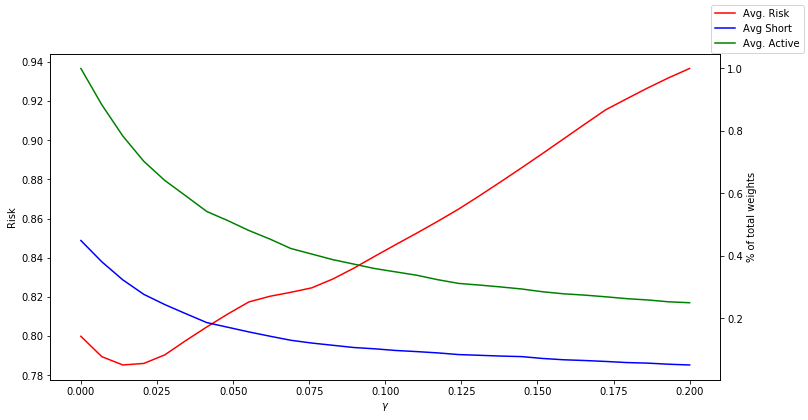

In [22]:
# Plotting
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df['avg_risk'],label='Avg. Risk' ,color='r')
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Risk')

# instantiate a second axes that shares the same x-axis
ax2 = ax.twinx()   
ax2.plot(df['avg_short'], label = 'Avg Short',color='b')
ax2.plot(df['avg_active'], label = 'Avg. Active', color='g')
ax2.set_ylabel('% of total weights')

fig.legend()

## Experiment - Choosing the optimal regularization parameter by CV

In [90]:
# Number of Kfolds
num_folds = 10

# Tain and Test Window Size (Days)
win_size = 250
step_size = 21

# Grid for Gamma values
num = 30
gamma_grid = np.linspace(0,0.2,num)

#Initalising list for results
results = []


data=returns[:600]

## Outer Loop - Sliding window Train/Test split
for train_index,test_index in tqdm(generate_splits(data,win_size=win_size, step_size=step_size)):
    train  = returns.iloc[train_index]
    test = returns.iloc[test_index]

    ## Inner Loop - K-Fold test/train CV
    rnd_train = train.sample(frac=1,random_state=420)

    #Intialise to save all the k-fold sigmas
    kfold_sigma = np.empty([30,num_folds])

    for n,i in enumerate(range(0,num_folds*step_size,step_size)):

        # Index for Train/Test
        idx_test = np.r_[i:i+step_size]
        idx_train = np.r_[0:i,i+step_size:len(train)]

        # Train/Test set
        k_test = rnd_train.iloc[idx_test]
        k_train = rnd_train.iloc[idx_train]
        
        k_sigma = []
        for gamma in gamma_grid:
            # Minimize for k-fold Train Data
            opt_weights = minimize(k_train,gamma,norm='l1')

            # Compute metrics on k-fold Test Data
            metrics = measure_metrics(k_test,opt_weights)
            k_sigma.append(metrics[1])

    # Record all k-fold Test Data Sigmas for each gamma value
    kfold_sigma[:,n] = np.array(k_sigma)

    # Average k-fold Test Sigma for each Gamma value and return index of minimum value
    idx = np.argmin(np.mean(kfold_sigma, axis =1))

    # Choose the optimal Gamma
    opt_gamma = gamma_grid[idx]

    # Minimize for full Train Data with optimal Gamma from CV
    opt_weights = minimize(train,opt_gamma,norm='l1')

    # Compute metrics on Test Data for optimal weights
    metrics = measure_metrics(test,opt_weights)

    # Save the results
    results.append([*metrics])

df = pd.DataFrame(results, columns=['Return','Risk', 'Sharpe','Short','Active'])
df.head()

,Return,Risk,Sharpe,Short,Active
0,0.022590,0.288696,0.008972,16,37
1,0.085939,0.182955,0.360410,2,13
2,0.036918,0.090887,0.186143,15,30
3,0.012994,0.235427,-0.029761,4,18
4,0.050708,0.388161,0.079111,2,12


## Cutoff point for Rounding

In [28]:
def cutoff_simulation(returns,gamma_val=0.2,constr='ssu',norm='l1'):
    # List to collect metrics
    results =[]
    weights = []

    ## Sliding Window Optimization
    for train_index,test_index in tqdm(generate_splits(returns,win_size=250,step_size=21)):
        train  = returns.iloc[train_index]
        test = returns.iloc[test_index]

        # Minimize for Train Data
        opt_weights = minimize(train,gamma_val,constr,norm)

        # Compute metrics on Test Data for optimal weights
        Return,Risk,Sharpe,Short,Active = measure_metrics(test,opt_weights)
        weights.append(opt_weights)
        results.append([Return,Risk,Sharpe,Short,Active])

    return weights,pd.DataFrame(results, columns=['Return','Risk', 'Sharpe','Short','Active'])

Text(0, 0.5, 'log(abs(weights))')

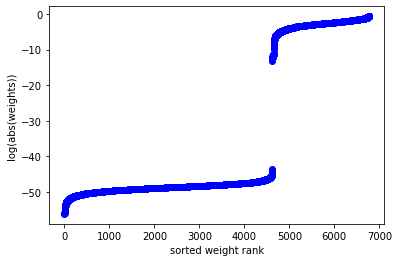

In [29]:
# Run Simulation to find Cutoff for rounding
weights, results = cutoff_simulation(returns[:20000],constr='ssu',norm='l1')
test_weights = [item for sub_list in weights for item in sub_list]

# Absolut and sort weights
abs_weights = np.sort(np.abs(test_weights))

# Compute Rank of weights
rank = abs_weights.argsort()

# Plotting
fig,ax = plt.subplots()
ax.plot(rank,np.log(abs_weights),'bo')
ax.set_xlabel("sorted weight rank")
ax.set_ylabel("log(abs(weights))")

In [30]:
# Approximate Cutoff for rounding
cutoff = np.exp(-20)
print(cutoff)

2.061153622438558e-09
